In [1]:
import tensorflow as tf
from tensorflow.python.keras import Input
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.engine.keras_tensor import KerasTensor
from tensorflow.python.keras.engine.functional import Functional
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense
from tensorflow.python.keras.regularizers import l1, l2
import os

from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning, prune_low_magnitude

from callbacks import all_callbacks


### Import the MNIST data class and call it.

Original dataset and modified dataset with modifiable resolution is shown below.

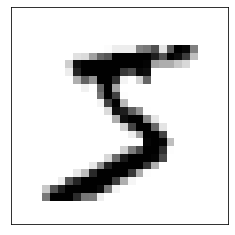

In [12]:
import MNIST_dataset as mnist
size_final = 28

data = mnist.MNISTData(size_initial=28, size_final=size_final, color_depth=8)
train= data.x_train
ax = plt.subplot(1, 1 , 1)

plt.imshow(train[0].reshape(size_final,size_final), cmap='gray_r')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)


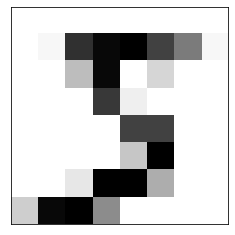

In [2]:
import MNIST_dataset as mnist

#Choose the final size of your image dataset
size_final = 8

data_zoom = mnist.MNISTData(size_initial=20, size_final=size_final, color_depth=5, flat=True)
train= data_zoom.x_train
ax = plt.subplot(1, 1 , 1)

plt.imshow(train[0].reshape(size_final,size_final), cmap='gray_r')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# Autoencoder using Keras
The aim of this class is to implement a simple autoencoder for the MNIST data and then build an autoencoder that is
able to classify MNIST data in its latent dimension.

Code partially adapted from [Keras Documentation](https://blog.keras.io/building-autoencoders-in-keras.html).

In [3]:
class Autoencoder:
    """Autoencoder Class"""

    def __init__(self, data: mnist.MNISTData, num_classes=10, pruned = False):
        self.x_train = data.x_train
        self.x_test = data.x_test
        self.y_train = data.y_train
        self.y_test = data.y_test

        self.num_classes = num_classes
        self.pruned = pruned
        self.input_shape = (self.x_train.shape[-1],)
        self.input = Input(shape=self.input_shape, name='encoder_input')
        self.latent_dim = 2

        self.encoder = None
        self.encoder_model = None
        self.decoder = None
        self.decoder_model = None
        self.latent_classifier = None
        self.classifier = None
        self.autoencoder = None

        self.history = None

        self.pruning_params = {"pruning_schedule" : pruning_schedule.ConstantSparsity(0.85, begin_step=2000, end_step=10000, frequency=100)}
    
    def build_encoder(self):
        """Build your encoder architecture and store the output in self.encoder. 
        The final encoding dimension is 2."""

        self.encoder = Dense(32, name='fc1', activation='relu')(self.input)
        if self.pruned:
            self.encoder = prune_low_magnitude(Dense(16, name='fc2_prun',  activation='relu'), **self.pruning_params)(self.encoder) 
        
        if not self.pruned:
            self.encoder = Dense(16, name='fc2',  activation='relu')(self.encoder)   

        self.encoder = Dense(self.latent_dim,  activation='relu', name = 'encoder_output')(self.encoder)
        #building a model for the encoder in order to be able to predict and plot the latent dimension
        self.encoder_model = Model(self.input, self.encoder, name='encoder')

    def build_decoder(self):
        """Build the decoder architecture."""
        if self.encoder is None:
            raise RuntimeError("The encoder has to be built before you can build the decoder!")

        if self.pruned:
            self.decoder = prune_low_magnitude(Dense(16,  name='fc3_pruned', activation='relu'), **self.pruning_params)(self.encoder)
        
        if not self.pruned:
            self.decoder = Dense(16, name='fc3', activation='relu')(self.encoder)
        self.decoder = Dense(32, name='fc4', activation='relu')(self.decoder)     
        
        self.decoder = Dense(self.input_shape[0],activation='sigmoid', name='ecoder_output')(self.decoder)
        
    def build_classifier(self):
        """ Building the classifier architecture."""
        if self.encoder is None:
            raise RuntimeError("The encoder has to be built before you can build the classifier!")
        
        if self.pruned:
            self.latent_classifier = prune_low_magnitude(Dense(16, name='fc3_prunclass', activation='relu'), **self.pruning_params)(self.encoder)

        if not self.pruned:
            self.latent_classifier = Dense(16, name='fc3_class', activation='relu')(self.encoder)
        
        self.latent_classifier = Dense(32, name='fc4_class', activation='relu')(self.latent_classifier)
        self.latent_classifier = Dense(self.num_classes, activation='softmax', name='classifier_output')(self.latent_classifier)
    def build_autoencoder(self, use_latent_classifier=False):
        """ Build the whole autoencoder Model from self.encoder and self.decoder."""
        self.dir()
        
        if self.encoder is None:
            raise RuntimeError("The encoder has to be built before you can build the autoencoder!")
        if self.decoder is None:
            raise RuntimeError("The decoder has to be built before you can build the autoencoder!")
        
        if use_latent_classifier:
            if self.latent_classifier is None:
                raise RuntimeError("If you want to use the option with the latent classifier, you have to build it "
                                   "beforehand!")
            self.autoencoder = Model(self.input, outputs=[self.decoder, self.latent_classifier])
            self.autoencoder.compile(loss=['mse', 'categorical_crossentropy'], loss_weights=[1, 0.1], optimizer='adam',
                                     metrics="accuracy")
            if not self.pruned:
                self.autoencoder.save('model/AE_model/KERAS_check_model_w_classifier.h5')
            if self.pruned:
                self.autoencoder.save('model/AE_model/KERAS_check_pruned_model_w_classifier.h5')
    
        else:
            self.autoencoder = Model(self.input, outputs=self.decoder, name = 'autoencoder')
            self.autoencoder.compile(loss='mse', optimizer='adam') 
            if not self.pruned:
                self.autoencoder.save('model/AE_model/KERAS_check_model_wo_classifier.h5')
            if self.pruned:
                self.autoencoder.save('model/AE_model/KERAS_check_pruned_model_wo_classifier.h5')
        self.autoencoder.summary()
        
    def fit_data(self, batch_size=256, epochs=30, use_latent_classifier=False):
        """Write the fit function for the autoencoder. 
        Storing the fit history in self.history to be able to plot the fitting scores."""
        
        callbacks = all_callbacks(stop_patience = 1000,
                              lr_factor = 0.5,
                              lr_patience = 10,
                              lr_epsilon = 0.000001,
                              lr_cooldown = 2,
                              lr_minimum = 0.0000001,
                              outputDir = 'model/AE_model/model_2')
        callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep()) 
        
        if use_latent_classifier:
            self.history = self.autoencoder.fit(self.x_train, [self.x_train, self.y_train],
                                                validation_data=(self.x_test, [self.x_test, self.y_test]),
                                                batch_size=batch_size, epochs=epochs,
                                                shuffle=True, callbacks=callbacks.callbacks)
            self.autoencoder = strip_pruning(self.autoencoder)
            if not self.pruned:
                self.autoencoder.save('model/AE_model/KERAS_check_best_model_classifier.h5')
            if self.pruned:
                self.autoencoder.save('model/AE_model/KERAS_check_pruned_best_model_classifier.h5')
        else:                         
            self.history = self.autoencoder.fit(self.x_train, self.x_train,
                                                validation_data=(self.x_test, self.x_test),
                                                batch_size=batch_size, epochs=epochs,
                                                shuffle=True, callbacks=callbacks.callbacks)  
            self.autoencoder = strip_pruning(self.autoencoder)
            if not self.pruned:
                self.autoencoder.save('model/AE_model/KERAS_check_best_model.h5')
            if self.pruned:
                self.autoencoder.save('model/AE_model/KERAS_check_pruned_best_model.h5')

        self.history = self.history.history

    def dir(self):
        """Creation of the folders path to store the results."""
        dir = os.path.join("images")
        if not os.path.exists(dir):
            os.mkdir(dir)
        dir2 = os.path.join("./images/AE")
        if not os.path.exists(dir2):
            os.mkdir(dir2)
        dir3 = os.path.join("model")
        if not os.path.exists(dir3):
            os.mkdir(dir3)
        dir4 = os.path.join("./model/AE_model")
        if not os.path.exists(dir4):
            os.mkdir(dir4)
        
    
    def plot_score(self, use_latent_classifier = False, model_name=None):
        """Plots the scores achieved during the fitting."""
        if use_latent_classifier is False:
            plt.plot(self.history['loss'])
            plt.plot(self.history['val_loss'])
            plt.ylabel('Model Accuracy')
        else:
            plt.plot(self.history['classifier_output_accuracy'])
            plt.plot(self.history['val_classifier_output_accuracy'])
            plt.ylabel('Classifier Accuracy')
        
        plt.xlabel('Epoch')        
        plt.legend(['Train', 'Test'], loc='best')
        plt.title('Accuracy of {model_name}'.format(model_name=model_name))
        
        plt.savefig('./images/AE/Accuracy of {model_name}.png'.format(model_name=model_name))
        
        plt.show()

    def plot_latent_dimension(self, model_name = None):
        """Plots the latent dimension of the autoencoder."""
        prediction = self.encoder_model.predict(self.x_test)
        fig = plt.figure(figsize=(10, 10))
        fig.patch.set_facecolor("white")
        plt.scatter(prediction[:, 0], prediction[:, 1], c=np.argmax(self.y_test, axis=1), cmap="Set3")
        plt.colorbar()
        plt.title('Latent space {model_name}'.format(model_name=model_name))


        plt.savefig('./images/AE/Latent dimension of {model_name}.png'.format(model_name=model_name))

        plt.show()

    def plot_reco(self, use_latent_classifier = False, model_name = None):
        """Plotting reconstructed images"""
        
        n = 6
        plt.figure(figsize=(10, 3))
        reco_imgs = self.autoencoder.predict(self.x_test)
        img_size = int(np.sqrt(self.input_shape[0]))

        
        if use_latent_classifier :
            raise RuntimeError("You are considering the autoencoder with classifier!")
        else:
        
            for i in range(n):
                # Display original MNIST
                ax = plt.subplot(2, n, i + 1)
                plt.imshow(self.x_test[i].reshape(img_size,img_size), cmap='gray_r')
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)

                # Display reconstructed MNIST            
                ax = plt.subplot(2, n, i + n + 1)
                plt.imshow(reco_imgs[i].reshape(img_size,img_size), cmap='gray_r')
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
            
            plt.savefig('./images/AE/reconstructed images{model_name}.png'.format(model_name=model_name))
            plt.show()
            
    def plot_latent(self):
        n = 6
        plt.figure(figsize=(10, 3))
        reco_imgs = self.encoder_model.predict(self.x_test)
        img_size = int(np.sqrt(self.input_shape[0]))

        ax = plt.subplot(1, 1, 1)
        plt.imshow(reco_imgs[1].reshape(2,1), cmap='gray_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        plt.show()


It is built the standard autoencoder, *without classifier* here, and the MNIST data class called before is used. 
The model is fitted and adequate plots are reproduced, 
as well as the comparison between orginal MNIST dataset and reconstructed images.

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 64)]              0         
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
encoder_output (Dense)       (None, 2)                 34        
_________________________________________________________________
dense_2 (Dense)              (None, 16)                48        
_________________________________________________________________
dense_3 (Dense)              (None, 32)                544       
_________________________________________________________________
ecoder_output (Dense)        (None, 64)                

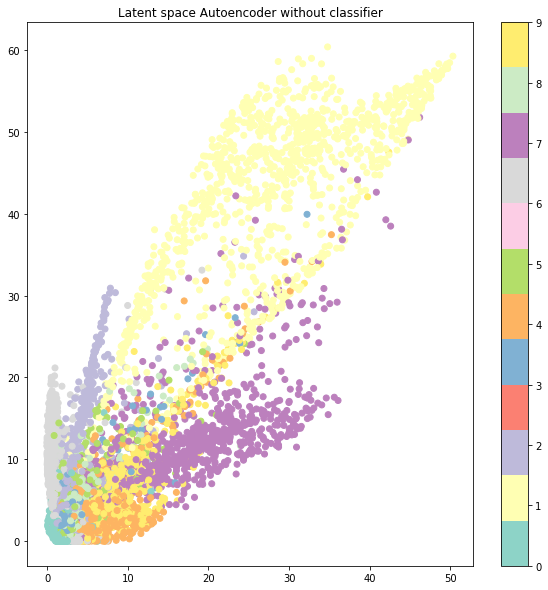

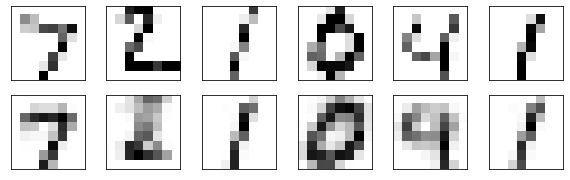

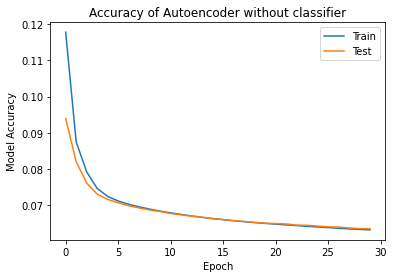

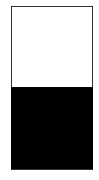

In [4]:
network = Autoencoder(data_zoom, pruned=False)
network.build_encoder()
network.build_decoder()
network.build_autoencoder()
network.fit_data(epochs=30)
network.plot_latent_dimension("Autoencoder without classifier")
network.plot_reco(model_name="complete")
network.plot_score(use_latent_classifier=False, model_name="Autoencoder without classifier")
network.plot_latent()


Instructions for updating:
Please use `layer.add_weight` method instead.
Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 64)]              0         
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
prune_low_magnitude_dense_1  (None, 16)                1042      
_________________________________________________________________
encoder_output (Dense)       (None, 2)                 34        
_________________________________________________________________
prune_low_magnitude_dense_2  (None, 16)                82        
_________________________________________________________________
dense_3 (Dense)              (None, 32)                544       
________________________________________________

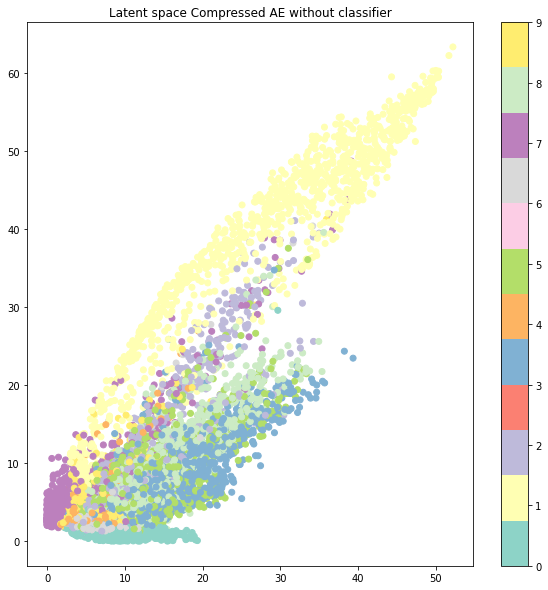

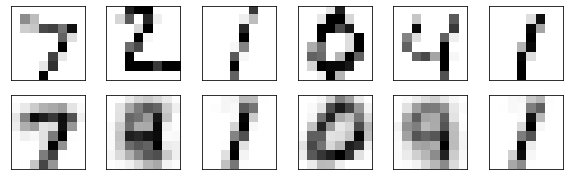

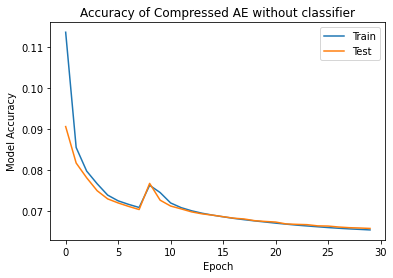

In [4]:
network = Autoencoder(data_zoom, pruned=True)
network.build_encoder()
network.build_decoder()
network.build_autoencoder()
network.fit_data()
network.plot_latent_dimension("Compressed AE without classifier")
network.plot_reco(model_name=" compressed")
network.plot_score(use_latent_classifier=False,model_name="Compressed AE without classifier")


Repeating the same procedure for the autoencoder with classifier.

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 64)]         0                                            
__________________________________________________________________________________________________
fc1 (Dense)                     (None, 32)           2080        encoder_input[0][0]              
__________________________________________________________________________________________________
fc2 (Dense)                     (None, 16)           528         fc1[0][0]                        
__________________________________________________________________________________________________
encoder_output (Dense)          (None, 2)            34          fc2[0][0]                        
_______________________________________________________________________________________

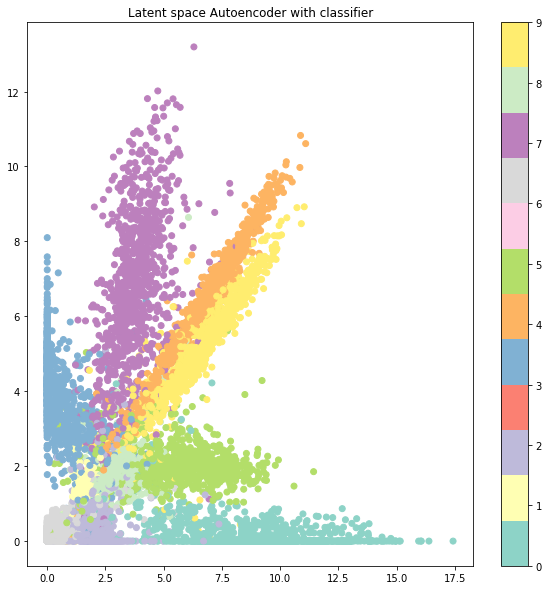

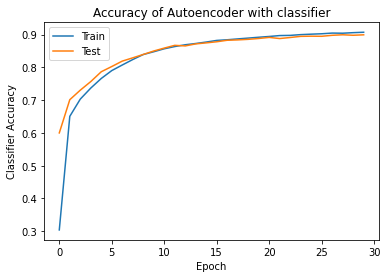

In [4]:
network_with_classifier = Autoencoder(data_zoom, pruned=False)
network_with_classifier.build_encoder()
network_with_classifier.build_decoder()
network_with_classifier.build_classifier()
network_with_classifier.build_autoencoder(use_latent_classifier=True)
network_with_classifier.fit_data( batch_size=256,epochs=30, use_latent_classifier=True)
network_with_classifier.plot_latent_dimension("Autoencoder with classifier")
network_with_classifier.plot_score(use_latent_classifier=True,model_name="Autoencoder with classifier")

In [12]:
import time

img = data_zoom.x_test[0].reshape(1,-1)
start_time = time.time()
network_with_classifier.autoencoder.predict(img)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.1650536060333252 seconds ---


Instructions for updating:
Please use `layer.add_weight` method instead.
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 64)]         0                                            
__________________________________________________________________________________________________
fc1 (Dense)                     (None, 32)           2080        encoder_input[0][0]              
__________________________________________________________________________________________________
prune_low_magnitude_fc2_prun (P (None, 16)           1042        fc1[0][0]                        
__________________________________________________________________________________________________
encoder_output (Dense)          (None, 2)            34          prune_low_magnitude_fc2_prun[0][0
______________

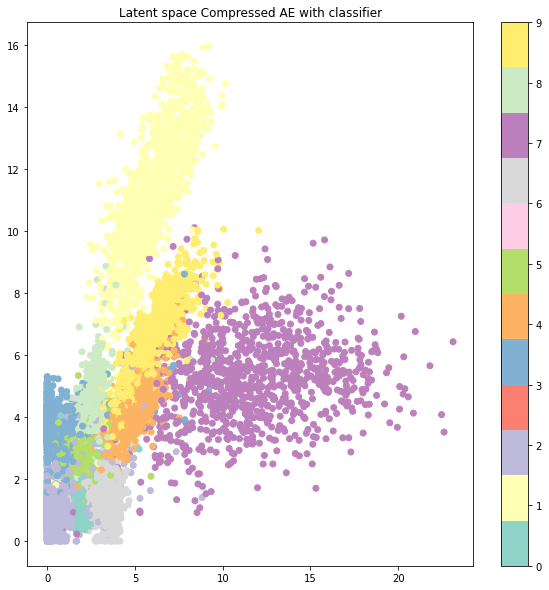

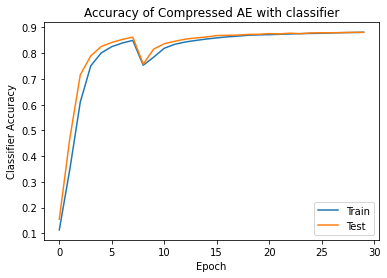

In [13]:
network_with_classifier = Autoencoder(data_zoom, pruned=True)
network_with_classifier.build_encoder()
network_with_classifier.build_decoder()
network_with_classifier.build_classifier()
network_with_classifier.build_autoencoder(use_latent_classifier=True)
network_with_classifier.fit_data(use_latent_classifier=True)
network_with_classifier.plot_latent_dimension("Compressed AE with classifier")
network_with_classifier.plot_score(use_latent_classifier=True,model_name="Compressed AE with classifier")

In [14]:

img = data_zoom.x_test[0].reshape(1,-1)
start_time = time.time()
network_with_classifier.autoencoder.predict(img)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.09423089027404785 seconds ---
